# Simulation


## 1. Simulate data according to the proposed model.

In [1]:
%pip install numpy matplotlib scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 24.3 MB/s  0:00:00m0:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [2]:
# Defining eta function

def eta_linear(x, eta_max):
    """Linear noise: η(x) = η_max * (eta_max + 0.4*(x+1)/2)"""
    x_flat = x if x.ndim == 1 else np.mean(x, axis=1)
    return eta_max * (eta_max + 0.4 * (x_flat + 1) / 2)

def eta_nonLinear(x,eta_max):
    """
    Instance-dependent noise function eta(x) in [0, eta_max]
    Here: smooth nonlinear function
    """
    return eta_max * (0.5 + 0.5 * np.sin(2 * np.pi * x))

Text(0, 0.5, 'η(x)')

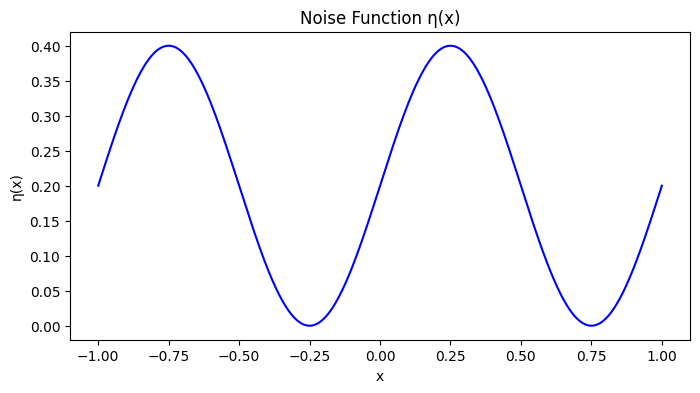

In [3]:
# Plotting eta function
x_vals = np.linspace(-1, 1, 500)
eta_vals = eta_nonLinear(x_vals, eta_max=0.4)
plt.figure(figsize=(8, 4))
plt.plot(x_vals, eta_vals, label='η(x)', color='blue')
plt.title('Noise Function η(x)')
plt.xlabel('x')
plt.ylabel('η(x)')

In [4]:
# Generate data
def generate_data(m: int, d: int, eta_func, eta_max):
    # Generate X uniformly in [-1, 1]^d
    X = np.random.uniform(-1, 1, size=(m, d))
    
    # Identifiability condition: true labels Y=+1
    Y = np.ones(m)
    
    # Compute true noise levels
    eta_true = eta_func(X[:,0], eta_max)
    
    # Generate corrupted labels Z
    Z = np.zeros(m,  dtype=np.int_)
    for i in range(m):
        # Flip label with probability η(X_i)
        if np.random.rand() < eta_true[i]:
            Z[i] = -Y[i]  # Flip
        else:
            Z[i] = Y[i]   # Keep
    
    return X, Y, Z, eta_true

In [5]:
# Test
eta_max=0.4
N = 10
m = 500
d = 1


X, Y, Z, eta_true = generate_data(m, d, eta_linear, eta_max)

print(f"Generated {m} samples in dimension d={d}")
print(f"X shape: {X.shape}")
print(f"Y values: {np.unique(Y)} (counts: {np.bincount(((Y + 1)//2).astype(int))})")
print(f"Z values: {np.unique(Z)} (counts: {np.bincount(((Z + 1)//2).astype(int))})")
print(f"Empirical flip rate: {np.mean(Y != Z):.3f}")
print(f"True average η: {np.mean(eta_true):.3f}")


Generated 500 samples in dimension d=1
X shape: (500, 1)
Y values: [1.] (counts: [  0 500])
Z values: [-1  1] (counts: [131 369])
Empirical flip rate: 0.262
True average η: 0.240


## 2. Implement the estimator of η that you proposed.

In [6]:
def gaussian_kernel (u):
    """
    Symmetrical Gaussian kernel function
    u: vector in R^d
    """
    return np.exp(-0.5 * np.dot(u, u)) / (2 * np.pi)**(len(u)/2)


In [7]:
def eta_estimator(X,Z,x,h):
    "Nadaraya-Watson estimator of eta at point x"
    
    eta_tilde = 0.0
    denominator = 0.0

    for i in range(len(X)):
        u = (X[i] - x) / h
        K = gaussian_kernel(u)
        eta_tilde += (1-Z[i])*K
        denominator += K
    if denominator == 0:
        return 0.0

    eta_tilde = eta_tilde/(2*denominator)
    return(eta_tilde)


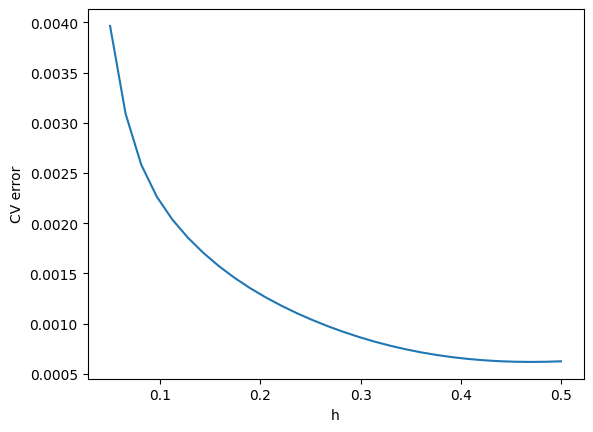

In [8]:
# Cross-validation to chose h

def cross_validation(eta,X,Z,h):
    error = 0
    n = X.shape[0]

    for i in range(X.shape[0]):
        # Leave-one-out
        cross_X = np.delete(X,i,0)
        cross_Z = np.delete(Z,i,0)

        eta_hat_i = eta_estimator(cross_X,cross_Z,X[i],h)
        error+= (eta[i] - eta_hat_i)**2
    
    return(error/n)

#hs = np.linspace(1, 2, 30)
hs = np.linspace(0.05, 0.5, 30)
errs = [cross_validation(eta_true,X, Z, h) for h in hs]

plt.plot(hs, errs)
plt.xlabel("h")
plt.ylabel("error")
plt.show()


    

- Small h → high variance, noisy estimator
- Large h → more smoothing, lower variance

In [14]:
# Select optimal h
h_opt = hs[np.argmin(errs)]
print("Optimal h:", h_opt)

Optimal h: 0.4689655172413793


In [16]:
# def h_optimal(X,Z,eta_true,a,b,nbr_pas):
#     optimal_h = 0
#     min_error = np.inf
#     for h in  np.linspace(a,b,nbr_pas):
#         error = cross_validation(eta_true,X,Z,h)
#         if error < min_error :
#                 optimal_h = h
#                 min_error = error
#     return(optimal_h)


# h_opt = h_optimal(X,Z,eta_true,0.05,0.5,30)
# print("Optimal h:", h_opt)

Optimal h: 0.4689655172413793


In [19]:
X_test, Y_test, Z_test, eta_true = generate_data(m,d,eta_linear,eta_max)
estimated_eta = []
for x in X_test :
    estimated_eta.append(eta_estimator(X,Z,x,h_opt))

print(f"Estimated value of eta {estimated_eta}")
print(f"Real value of eta : {eta_true}")

Estimated value of eta [np.float64(0.22298966579455612), np.float64(0.22237423796583572), np.float64(0.3180589230039736), np.float64(0.22247492348490366), np.float64(0.2234735624131223), np.float64(0.2953726410116551), np.float64(0.24036646658534028), np.float64(0.2983744710304638), np.float64(0.22016996265485625), np.float64(0.24602845002838022), np.float64(0.22031807240917364), np.float64(0.22018047499191043), np.float64(0.3180827914014645), np.float64(0.22018814843014775), np.float64(0.25347340082039893), np.float64(0.23528075668345505), np.float64(0.2286031554177561), np.float64(0.31721339165440404), np.float64(0.22038254637670654), np.float64(0.2777959827547451), np.float64(0.32494063935491857), np.float64(0.25838990784036586), np.float64(0.3218845834764078), np.float64(0.22022502962417656), np.float64(0.2362335543365354), np.float64(0.2229205997918181), np.float64(0.29027091596277466), np.float64(0.32685849096242026), np.float64(0.2227628176921762), np.float64(0.2759739890377385)

## 3. Illustrate empirically its performance (estimation error, influence of the sample size m, the dimension d, and the noise level).

In [20]:
result_estimator = np.array(estimated_eta)

In [21]:
#Estimation error

def MSE(eta,eta_hat):
    error = 0
    error = (eta - eta_hat)**2
    
    return(np.mean(error))

print(MSE(eta_true,result_estimator))

0.0005486414851670698


Text(0, 0.5, 'm')

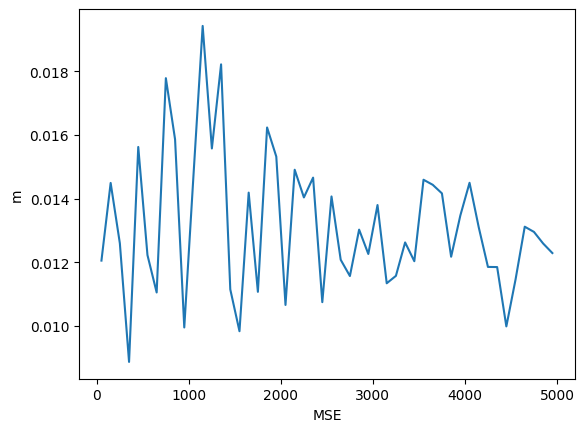

In [22]:
#Influence of the sample size m
m_values=np.array([50 + i*100 for i in range(50)])
data_generation_values=[generate_data(m, d, eta_linear, eta_max) for m in m_values]
X_test, Y_test, Z_test, eta_true = generate_data(30,d,eta_linear,eta_max=0.5)
data_points = []
for data in data_generation_values:
    data_estimation_values = [eta_estimator(data[0],data[2],x,0.43) for x in X_test]
    data_points.append(MSE(eta_true,data_estimation_values))


plt.plot(m_values, data_points)
plt.xlabel("MSE")
plt.ylabel("m")


Text(0, 0.5, 'MSE')

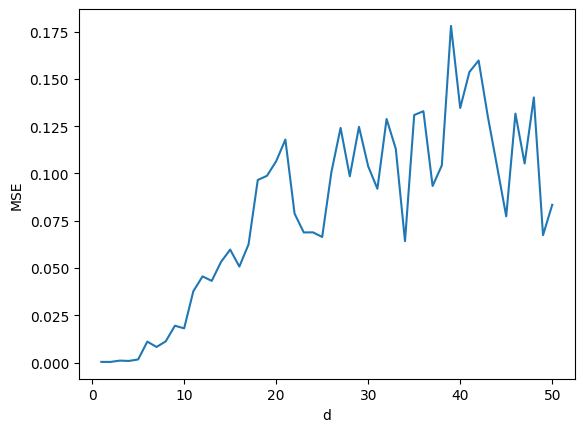

In [23]:
#Influence of the sample size d
N = 50
d_values=np.array([1 + i for i in range(50)])
m = 1000
data_generation_values=[generate_data(m, d, eta_linear, eta_max) for d in d_values]
data_test = [generate_data(30, d, eta_linear, eta_max) for d in d_values]
data_points = []
for n in range(N):
    data = data_generation_values[n]
    X_test = data_test[n][0]
    eta_true = data_test[n][3]
    data_estimation_values = [eta_estimator(data[0],data[2],x,0.43) for x in X_test]
    data_points.append(MSE(eta_true,data_estimation_values))


plt.plot(d_values, data_points)
plt.xlabel("d")
plt.ylabel("MSE")

In [212]:
#Influence of noise level
N=6
eta_values = np.round(np.linspace(0, 0.5, N), 1)
print(eta_values)
m = 500
d=1
data_generation_values=[generate_data(m, d, eta_constant, 0.1) for eta_max in eta_values]
data_test = [generate_data(30, d, eta_constant, eta_max) for eta_max in eta_values]
data_points = []
for n in range(N):
    data = data_generation_values[n]
    X_test = data_test[n][0]
    eta_true_test = data_test[n][3]
    h = h_optimal(data[0],data[2],data[3],0.1,1.5,30)
    print(h)
    data_estimation_values = [eta_estimator(data[0],data[2],x,h) for x in X_test]
    data_points.append(MSE(eta_true_test,data_estimation_values))


plt.plot(eta_values, data_points)
plt.xlabel("d")
plt.ylabel("MSE")



[0.  0.1 0.2 0.3 0.4 0.5]
1.5


KeyboardInterrupt: 